In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np


In [2]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def hammingDist(str1, str2): 
    i = 0
    count = 0
  
    while(i < len(str1)): 
        if(str1[i] != str2[i]): 
            count += 1
        i += 1
    return count 

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1


In [4]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state


#print(fermi_state(6))

Statevector([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  7.55411086e-18+0.11785113j,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  7.55411086e-18+0.23570226j,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.23570226j,
              7.55411086e-18+0.11785113j,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  7.55411086e-18+0.23570226j,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.35355339j,
              0.00000000e+00+0.23570226j,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.23570226j,
              0.00000000e+00+0.23570226j,  0.00000000e+00+0.j        ,
      

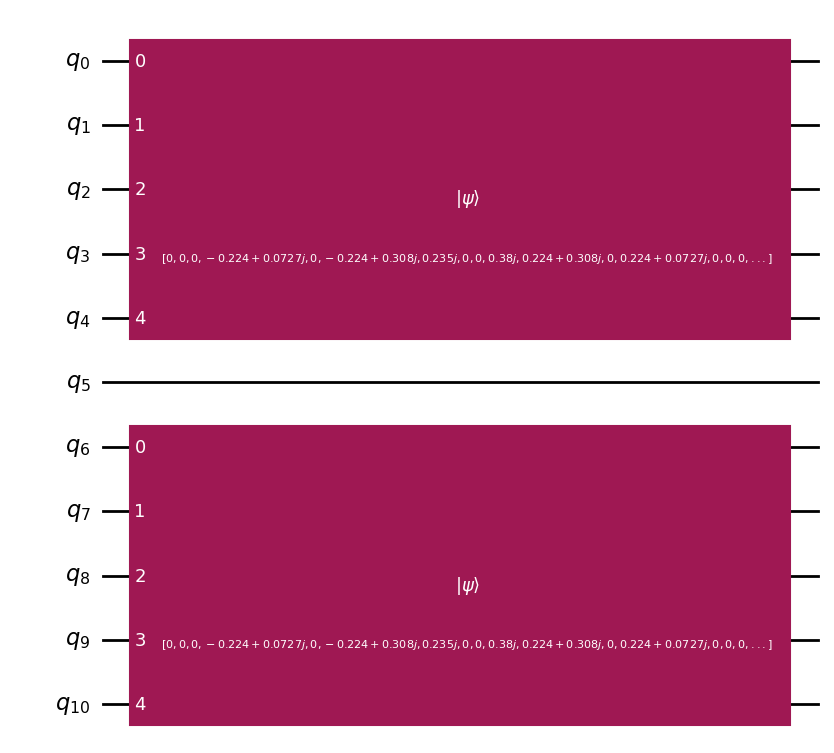

In [10]:
# Now we initialize the circuit with the fermi states for both up and down spin chains
N = 5 #number of sites
num_qubits = 2*N + 1
def fermi_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

qc = fermi_state_circuit(N)
qc.draw(output='mpl')


In [7]:
list(range(N)) + list(range(N+1,2*N+1))

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

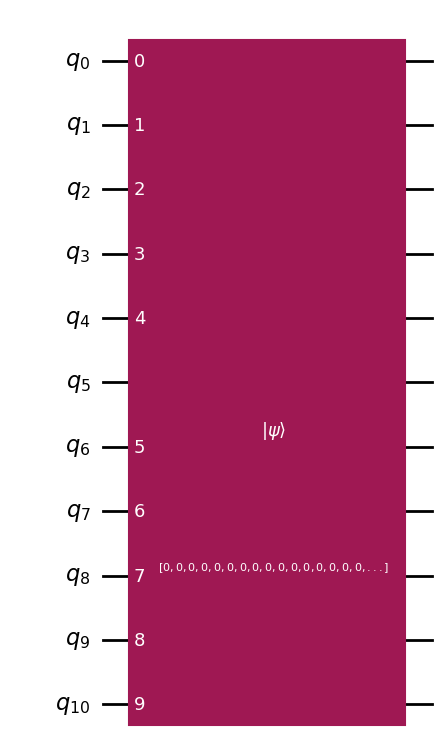

In [9]:
def fermi_state_circuit2(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_all = fermi_state(2*N)
    
    qc.initialize(fermi_state_all,list(range(N)) + list(range(N+1,2*N+1)))
    return qc

qc2 = fermi_state_circuit2(N)
qc2.draw(output='mpl')

In [11]:
from qiskit.quantum_info import Operator

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)

    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

In [12]:
trotter_steps = 2
angles = [np.pi/4,0,0]

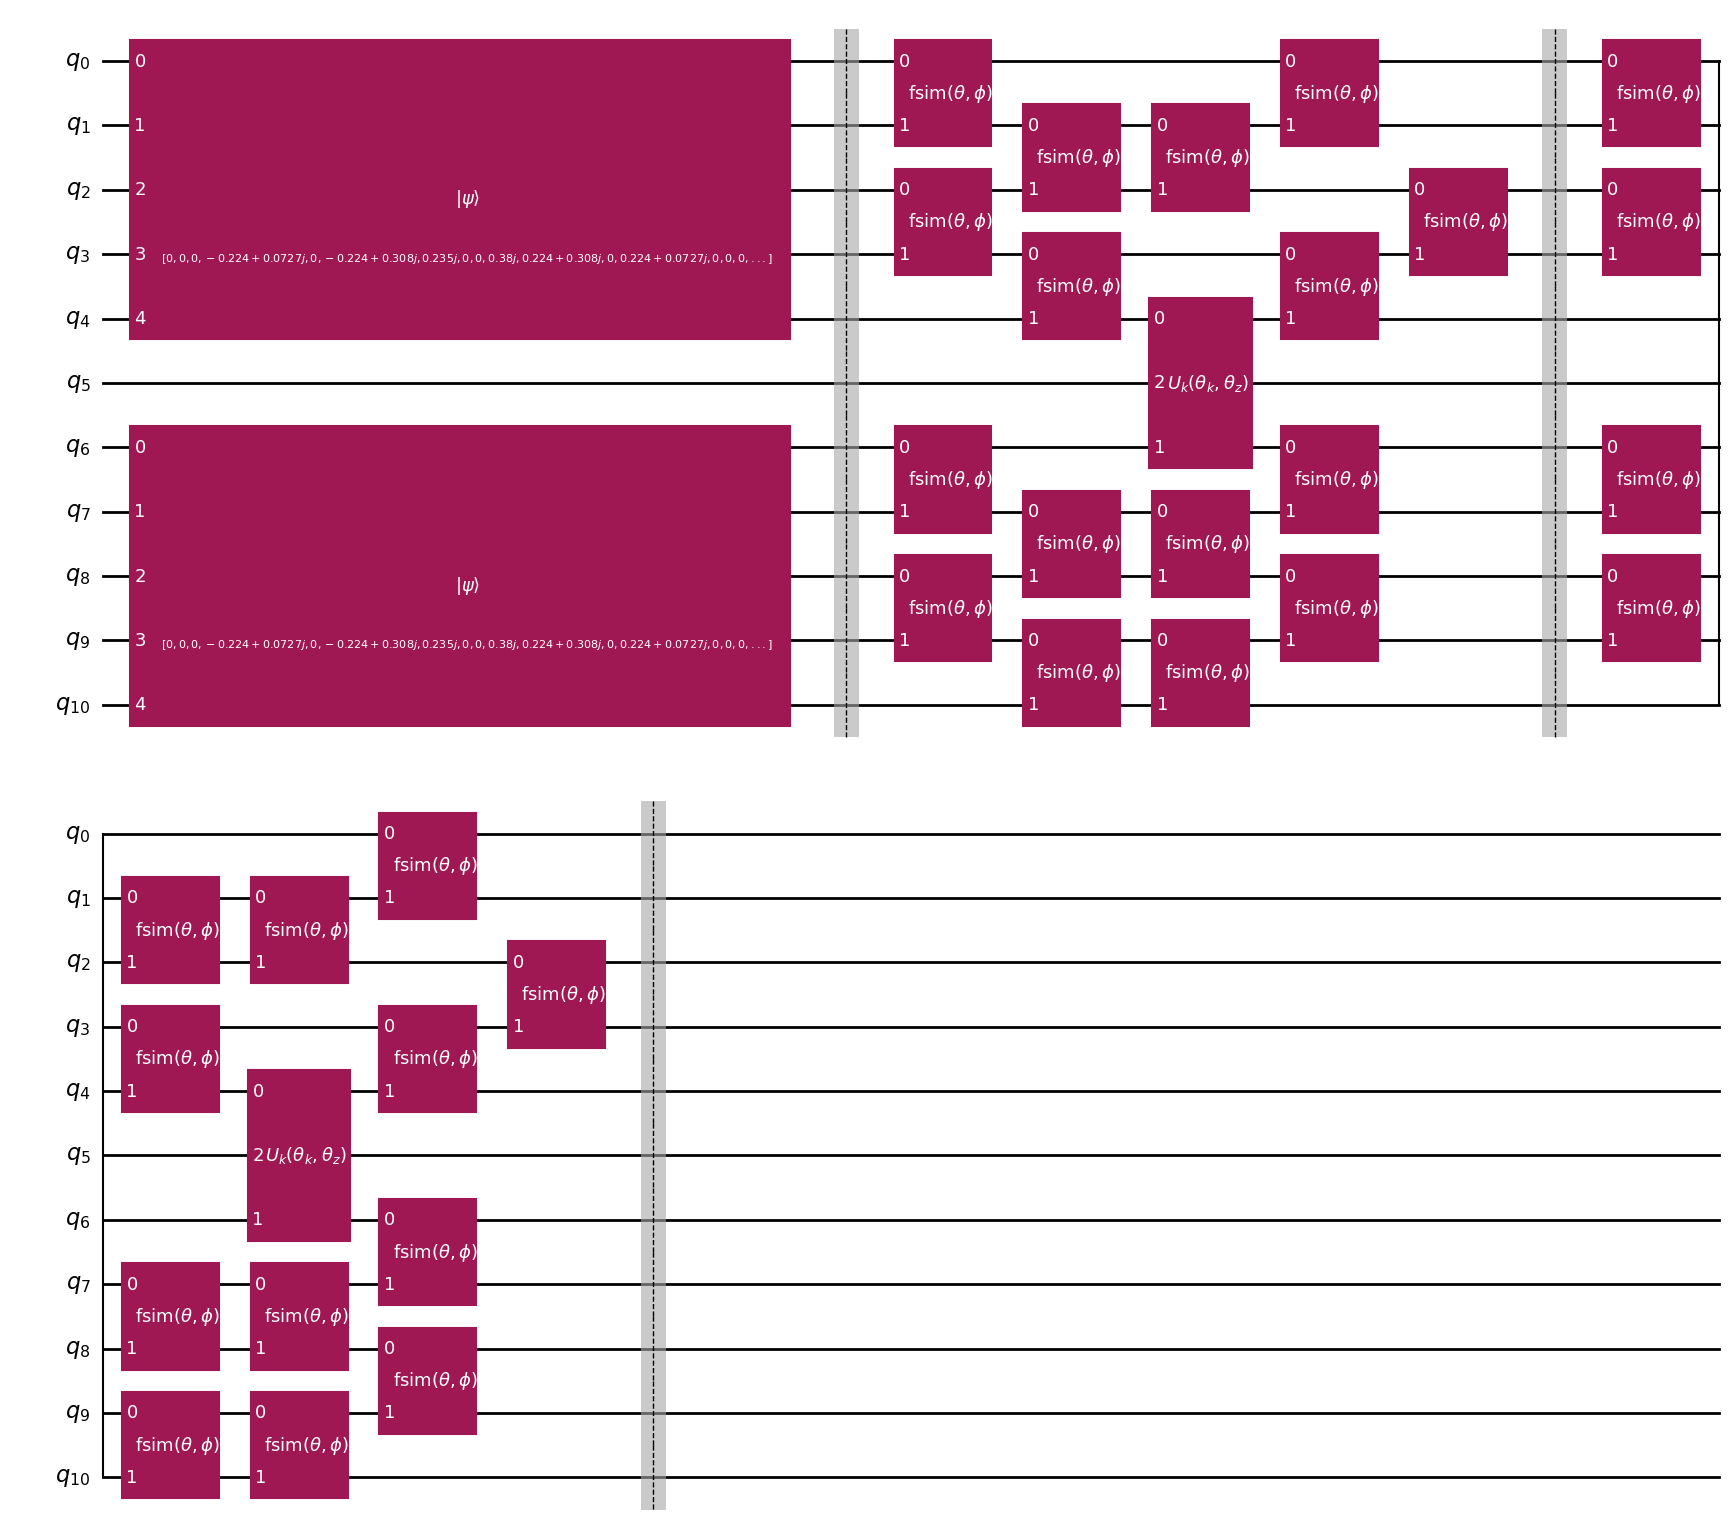

In [14]:
#Now we add the entire kondo circuit

# Let us use the direct 8 by 8 unitary now for the problem
import math as m
import cmath as cm

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary

def circuit_3(N, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N, num_cl_bits)
    qc.barrier()
    #qc.x(pos1-1)
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c-1,c+1,c],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

qc = circuit_3(N,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

## S_z measurement of impurity and leads


In [27]:
max_trotter_steps = 10
measured_bits =list(range(2*N + 1))
theta_k = np.pi/6
theta_z = np.pi/10

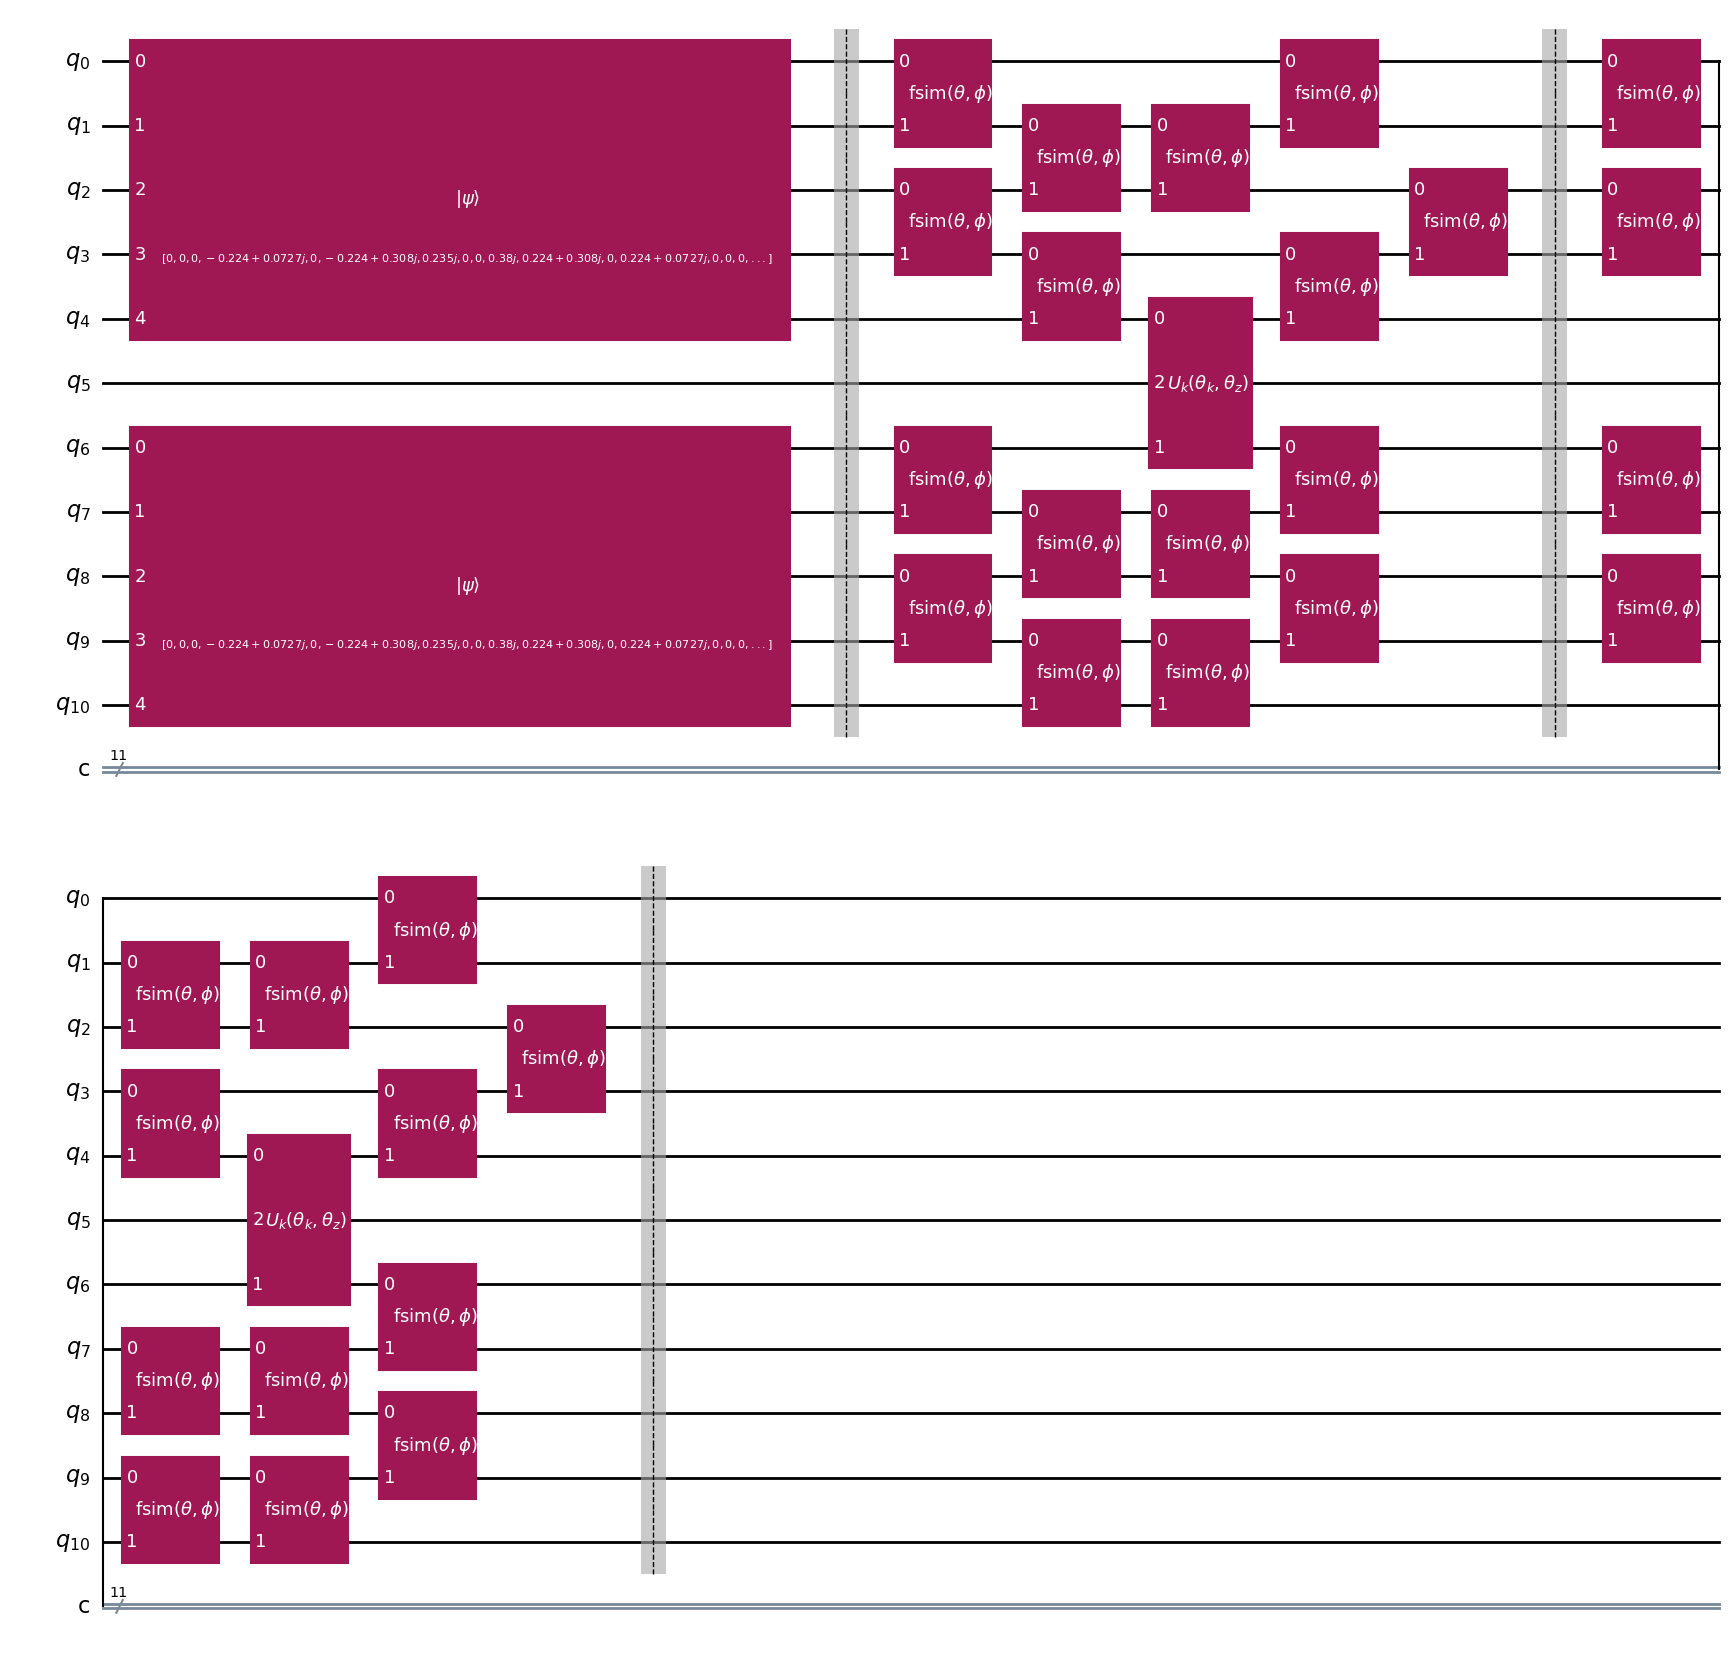

In [28]:
qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit_3(N, trotter_steps, angles, num_cl_bits = len(measured_bits),theta_k=theta_k,theta_z=theta_z, trotter_barriers = True)
    #qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[2].draw(output = "mpl")

In [29]:
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*max_trotter_steps
lead_1_observables = [SparsePauliOp('I'*(N-1) + 'Z' + 'I'*(N+1))]*max_trotter_steps
lead_2_observables = [SparsePauliOp('I'*(N+1) + 'Z' + 'I'*(N-1))]*max_trotter_steps

both_leads_observables = [SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*N)]*max_trotter_steps

estimator =  Estimator(approximation=True)
job_1 = estimator.run(qc_list,imp_observables,shots = None)
job_2 = estimator.run(qc_list,lead_1_observables,shots = None)
job_3 = estimator.run(qc_list,lead_2_observables,shots = None)
job_4 = estimator.run(qc_list,both_leads_observables,shots = None)
expectation_list_1 = list(job_1.result().values)
expectation_list_2 = list(job_2.result().values)
expectation_list_3 = list(job_3.result().values)
expectation_list_4 = list(job_4.result().values)




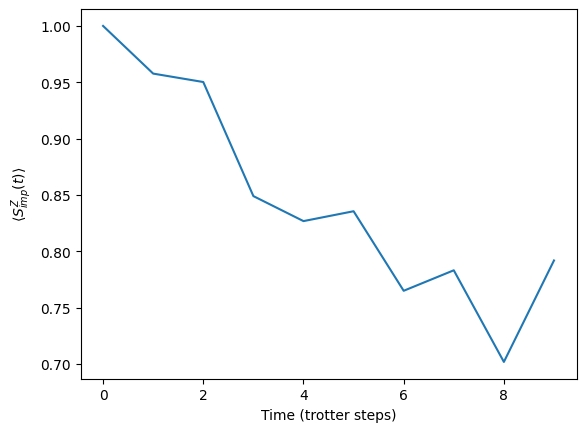

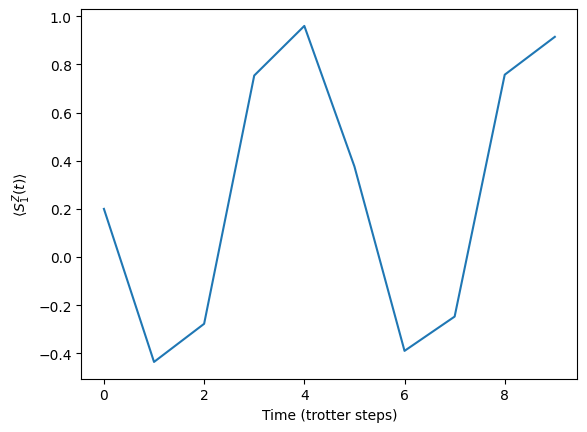

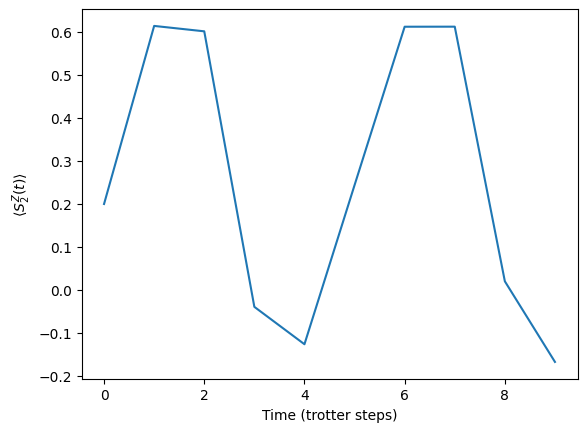

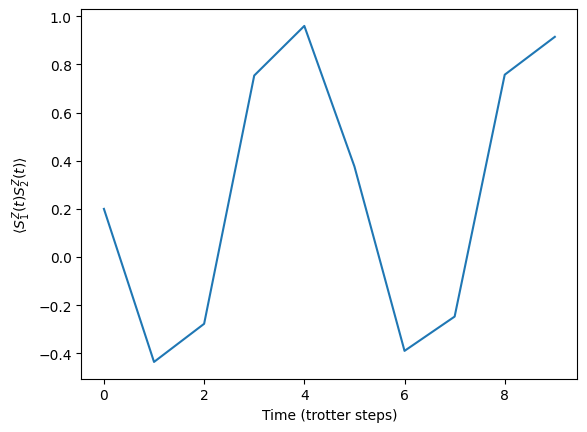

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(max_trotter_steps),expectation_list_1,label = 'Impurity')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_2,label = 'Lead 1')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{1}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_3,label = 'Lead 3')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{2}(t) \rangle$')
plt.show()

plt.plot(range(max_trotter_steps),expectation_list_2,label = 'Combined leads')
plt.xlabel('Time (trotter steps)')
plt.ylabel(r'$\langle S^Z_{1}(t)S^Z_{2}(t) \rangle$')
plt.show()

